In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.2 MB/s eta 0:00:00


In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader,Dataset

import snntorch as snn
from snntorch import utils
from snntorch import surrogate

import matplotlib.pyplot as plt
import numpy as np

import os
import io

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
root_dir = os.path.join(os.getcwd(), '/content/gdrive/My Drive/', 'Colab Notebooks/')
result_dir = os.path.join(root_dir, f'DeepLearning_FinalProject')
data_dir = os.path.join(result_dir, f'spectrograms_reduced_')

# make dir
os.makedirs(result_dir, exist_ok=True)

In [ ]:
#Spiking AutoEncoder
class SAE(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.encoder = nn.Sequential(nn.Conv2d(1, 6, 3,padding = 1,stride=2),
                          nn.BatchNorm2d(6),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.Conv2d(6, 12, 3,padding = 1,stride=2),
                          nn.BatchNorm2d(12),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.Conv2d(12, 16, 3,padding = 1,stride=2),
                          nn.BatchNorm2d(16),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.Flatten(start_dim = 1, end_dim = 3),
                          nn.Linear(90016, latent_dim), #this needs to be the final layer output size (channels * pixels * pixels)
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                          )
       # From latent back to tensor for convolution
        self.linearNet = nn.Sequential(nn.Linear(latent_dim,16*58*97),
                               snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))        #Decoder

        self.decoder = nn.Sequential(nn.Unflatten(1,(16,58,97)),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.ConvTranspose2d(16, 12, 3,padding = 1,stride=(2,2),output_padding=1),
                          nn.BatchNorm2d(12),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.ConvTranspose2d(12, 6, 3,padding = 1,stride=(2,2),output_padding=1),
                          nn.BatchNorm2d(6),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                          nn.ConvTranspose2d(6, 1, 3,padding = (2,1),stride=(2,2),output_padding=(1,0)),
                          snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #make large so membrane can be trained
                          )
    def forward(self, x):
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)

        #encode
        spk_mem=[];spk_rec=[];encoded_x=[]
        for step in range(num_steps): #for t in time
            spk_x,mem_x=self.encode(x) #Output spike trains and neuron membrane states
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)
        spk_rec=torch.stack(spk_rec,dim=2)
        spk_mem=torch.stack(spk_mem,dim=2)

        #decode
        spk_mem2=[];spk_rec2=[];decoded_x=[]
        for step in range(num_steps): #for t in time
            x_recon,x_mem_recon=self.decode(spk_rec[...,step])
            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)
        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)
        out = spk_mem2[:,:,:,:,-1] #return the membrane potential of the output neuron at t = -1 (last t)
        return out

    def encode(self,x):
        spk_latent_x,mem_latent_x=self.encoder(x)
        return spk_latent_x,mem_latent_x

    def decode(self,x):
        spk_x,mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2,mem_x2=self.decoder(spk_x)
        return spk_x2,mem_x2

In [ ]:
#Training
def train(network, trainloader, opti, epoch):

    network=network.train()
    train_loss_hist=[]
    for batch_idx, (noisy_img, real_img) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        noisy_img = noisy_img.to(device)

        print(noisy_img[:,0,:,:].shape)
        #Pass data into network, and return reconstructed image from Membrane Potential at t = -1
        x_recon = network(noisy_img) #Dimensions passed in: [Batch_size,Channels,Image_Width,Image_Length]

        #print(x_recon.shape)
        #print(real_img.shape)

        #Calculate loss
        loss_val = F.mse_loss(x_recon, real_img)

        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}')

        loss_val.backward()
        opti.step()

        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
            # NOTE: you need to create training/ and testing/ folders in your chosen path
            #utls.save_image((real_img+1)/2, f'training/epoch{epoch}_finalbatch_inputs.png')
            #utls.save_image((x_recon+1)/2, f'training/epoch{epoch}_finalbatch_recon.png')
            pass
    return loss_val

In [ ]:
#Testing
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    with torch.no_grad(): #no gradient this time
        for batch_idx, (noisy_img, real_img) in enumerate(testloader):
            real_img = real_img.to(device)#
            noisy_img = noisy_img.to(device)
            #labels = labels.to(device)
            x_recon = network(noisy_img)

            loss_val = F.mse_loss(x_recon, real_img)

            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}')#, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')

            if batch_idx == len(testloader)-1:
                #utls.save_image((real_img+1)/2, f'testing/epoch{epoch}_finalbatch_inputs.png')
                #utls.save_image((x_recon+1)/2, f'testing/epoch{epoch}_finalbatch_recons.png')
                pass
    return loss_val

# Dataset Generate

In [ ]:
# Dataloader to load train and test data for training Spiking Autoencodes
class NoisyDataset_(Dataset):

    def __init__(self, clean_data_dir, noisy_data_dir, len):
        self.clean_data_dir = clean_data_dir
        self.noisy_data_dir = noisy_data_dir
        self.len = len

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        clean = plt.imread(os.path.join(self.clean_data_dir, f'clean_spectrogram{idx}.png'), format='png').reshape(4, 462, 775)
        noisy = plt.imread(os.path.join(self.noisy_data_dir, f'noisy_spectrogram{idx}.png'), format='png').reshape(4, 462, 775)

        return noisy, clean

In [ ]:
# Dataloader to load train and test data for training Spiking Autoencodes
class NoisyDataset_components(Dataset):

    def __init__(self, clean_data_dir, noisy_data_dir, len):
        self.clean_data_dir = clean_data_dir
        self.noisy_data_dir = noisy_data_dir
        self.len = len

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        clean = plt.imread(os.path.join(self.clean_data_dir, f'clean_spectrogram{idx}.png'), format='png').reshape(4, 462, 775)[1,:,:].reshape(1, 462, 775)
        noisy = plt.imread(os.path.join(self.noisy_data_dir, f'noisy_spectrogram{idx}.png'), format='png').reshape(4, 462, 775)[1,:,:].reshape(1, 462, 775)

        return noisy, clean

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
clean_dir = os.path.join(data_dir, 'clean_audio_spectrogram')
noisy_dir = os.path.join(data_dir, 'noisy_audio_spectrogram')

# set the directory location for clean spectrogram, noisy spectrogram and length (or maximum) file number inside the directory
trainset = NoisyDataset_(clean_dir, noisy_dir, 10)

# batch size = 16 is found to be the optimal. Above 16 is causing Memory Exhaustion Error
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

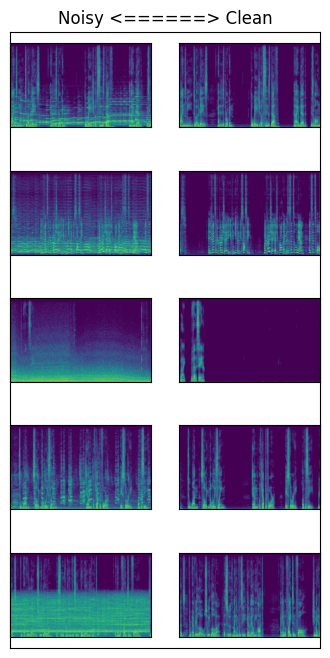

In [ ]:
a, b = next(iter(trainloader))

# select the first 10 samples in the batch to visualize in the grid plots below
idx = 1
plt.figure(figsize=(4,8))
plt.title('Noisy <======> Clean')
plt.xticks([])
plt.yticks([])
tot = min(5, a.shape[0])
for i in range(tot):
  plt.subplot(5,2,idx)
  plt.imshow(a[i].reshape(462, 775, 4), cmap='gray')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(5,2,idx+1)
  plt.imshow(b[i].reshape(462, 775, 4), cmap='gray')
  plt.xticks([])
  plt.yticks([])

  idx+=2

plt.show()

# Main

In [ ]:
# SNN parameters
spike_grad = surrogate.atan(alpha=2.0)# alternate surrogate gradient: fast_sigmoid(slope=25)
beta = 0.5 #decay rate of neurons
num_steps=5 #time
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1#spiking threshold (lower = more spikes are let through)
epochs=100 #number of epochs
max_epoch=epochs

In [ ]:
#Define Network and optimizer
net=SAE()
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(),
                            lr=0.0005,)
                            #betas=(0.9, 0.999),
                            #weight_decay=0.001)

In [ ]:
# Load pretrained model
net = SAE()
net = net.to(device)
#net.load_state_dict(torch.load(os.path.join(result_dir, 'model.pt'), weights_only=True))

In [ ]:
# reset cuda and delete cache
#del trainloader, trainset
#torch.cuda.empty_cache()

In [ ]:
clean_dir = os.path.join(data_dir, 'clean_audio_spectrogram')
noisy_dir = os.path.join(data_dir, 'noisy_audio_spectrogram')

# set the directory location for clean spectrogram, noisy spectrogram and length (or maximum) file number inside the directory
trainsetc = NoisyDataset_components(clean_dir, noisy_dir, 10)

# batch size = 16 is found to be the optimal. Above 16 is causing Memory Exhaustion Error
trainloaderc = torch.utils.data.DataLoader(trainsetc, batch_size=10, shuffle=True)

In [ ]:
#Run training and testing
for e in range(epochs):
    train_loss = train(net, trainloaderc, optimizer, e)
    #test_loss = test(net,test_loader,optimizer,e)

# Uncomment the below line to save the model
#torch.save(net.state_dict(), os.path.join(result_dir, 'model2.pt'))

torch.Size([10, 462, 775])
Train[0/100][0/1] Loss: 0.9051883220672607
torch.Size([10, 462, 775])
Train[1/100][0/1] Loss: 0.9051883816719055
torch.Size([10, 462, 775])
Train[2/100][0/1] Loss: 0.9051883816719055
torch.Size([10, 462, 775])
Train[3/100][0/1] Loss: 0.9051883816719055
torch.Size([10, 462, 775])
Train[4/100][0/1] Loss: 0.9051883220672607
torch.Size([10, 462, 775])
Train[5/100][0/1] Loss: 0.9051883220672607
torch.Size([10, 462, 775])
Train[6/100][0/1] Loss: 0.9051883816719055
torch.Size([10, 462, 775])
Train[7/100][0/1] Loss: 0.9051883220672607
torch.Size([10, 462, 775])
Train[8/100][0/1] Loss: 0.9051883220672607
torch.Size([10, 462, 775])
Train[9/100][0/1] Loss: 0.9051883220672607
torch.Size([10, 462, 775])
Train[10/100][0/1] Loss: 0.9051883816719055
torch.Size([10, 462, 775])
Train[11/100][0/1] Loss: 0.9051885008811951
torch.Size([10, 462, 775])
Train[12/100][0/1] Loss: 0.9051883816719055
torch.Size([10, 462, 775])
Train[13/100][0/1] Loss: 0.9051883816719055
torch.Size([10, 

KeyboardInterrupt: 

# Testing

Note: Below we use training data itself to test the model.

But a new test dataloader with testing data need to created once the model starts giving good predictions

In [ ]:
# Calling the test data loader
data = next(iter(trainloader))
noisy_data = data[0].float().to(device)
clean_data = data[1].float().to(device)
output = net(noisy_data)

In [ ]:
noisy_data.shape

torch.Size([2, 4, 462, 775])

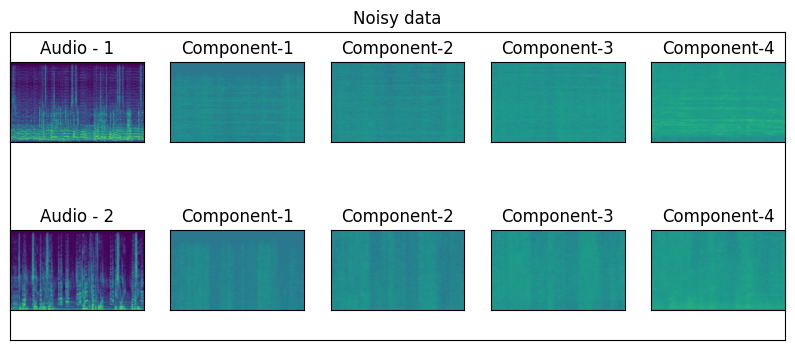

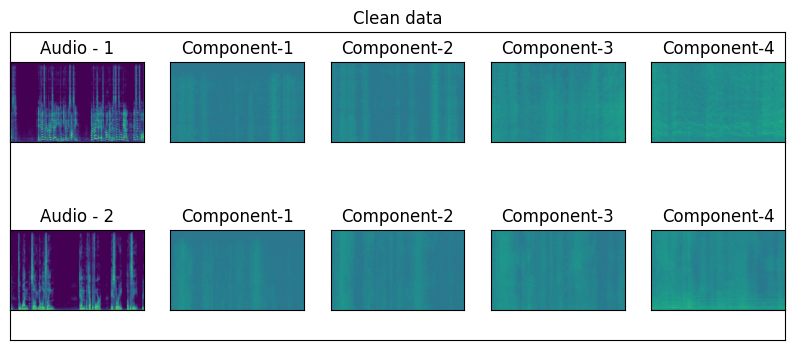

In [ ]:
a, b = next(iter(trainloader))
#print(a.shape[0])

############################################ Plot the noisy data ########################################################

# select the first 10 samples in the batch to visualize in the grid plots below
idx = 1
plt.figure(figsize=(10,4))
plt.title('Noisy data')
plt.xticks([])
plt.yticks([])

tot = min(2, a.shape[0])
for i in range(tot):

  plt.subplot(a.shape[0],5,idx)
  plt.title(f'Audio - {i+1}')
  plt.imshow(a[i].reshape(462, 775, 4))
  plt.xticks([])
  plt.yticks([])

  plt.subplot(a.shape[0],5,idx+1)
  plt.title('Component-1')
  plt.imshow(a[i][0])
  plt.xticks([])
  plt.yticks([])

  plt.subplot(a.shape[0],5,idx+2)
  plt.title('Component-2')
  plt.imshow(a[i][1])
  plt.xticks([])
  plt.yticks([])

  plt.subplot(a.shape[0],5,idx+3)
  plt.title('Component-3')
  plt.imshow(a[i][2])
  plt.xticks([])
  plt.yticks([])

  plt.subplot(a.shape[0],5,idx+4)
  plt.title('Component-4')
  plt.imshow(a[i][3])
  plt.xticks([])
  plt.yticks([])

  idx+=5

plt.show()


############################################ Plot the clean data ########################################################

# select the first 10 samples in the batch to visualize in the grid plots below
idx = 1
plt.figure(figsize=(10,4))
plt.title('Clean data')
plt.xticks([])
plt.yticks([])

tot = min(2, a.shape[0])
for i in range(tot):

  plt.subplot(b.shape[0],5,idx)
  plt.title(f'Audio - {i+1}')
  plt.imshow(b[i].reshape(462, 775, 4))
  plt.xticks([])
  plt.yticks([])

  plt.subplot(b.shape[0],5,idx+1)
  plt.title('Component-1')
  plt.imshow(b[i][0])
  plt.xticks([])
  plt.yticks([])

  plt.subplot(b.shape[0],5,idx+2)
  plt.title('Component-2')
  plt.imshow(b[i][1])
  plt.xticks([])
  plt.yticks([])

  plt.subplot(b.shape[0],5,idx+3)
  plt.title('Component-3')
  plt.imshow(b[i][2])
  plt.xticks([])
  plt.yticks([])

  plt.subplot(b.shape[0],5,idx+4)
  plt.title('Component-4')
  plt.imshow(b[i][3])
  plt.xticks([])
  plt.yticks([])

  idx+=5

plt.show()

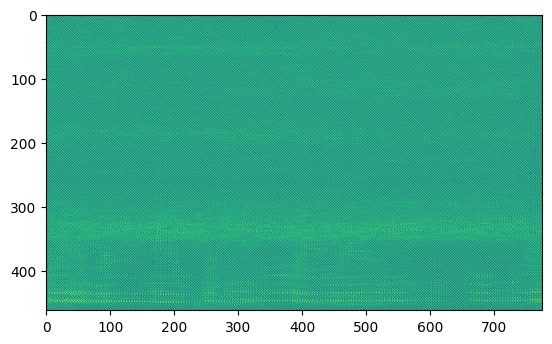

In [ ]:
plt.imshow(noisy_data[0].cpu().detach().numpy()[3])

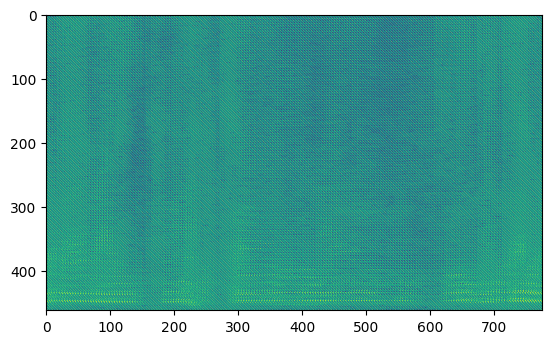

In [ ]:
plt.imshow(clean_data[0].cpu().detach().numpy()[3])

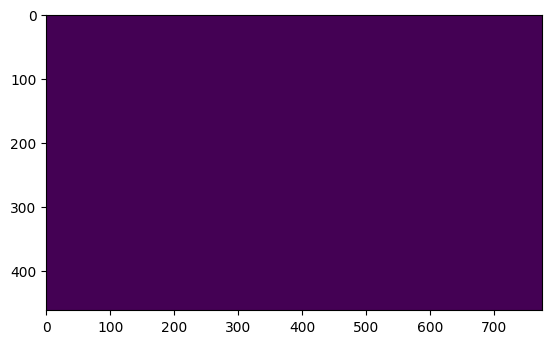

In [ ]:
plt.imshow(output[0].cpu().detach().numpy()[0])

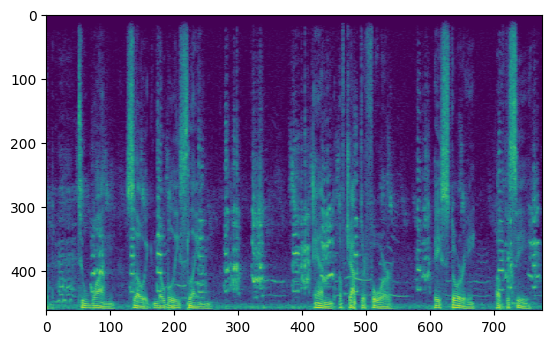

In [ ]:
plt.imshow(data[0].cpu().detach().numpy().reshape(462, 775, 4))

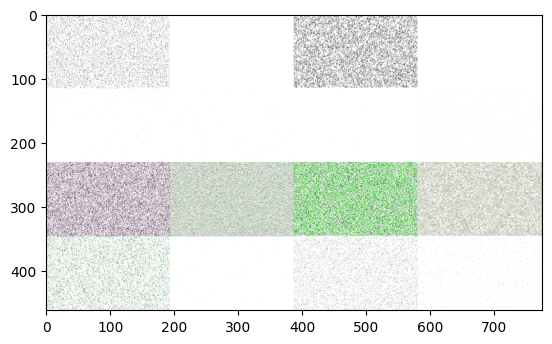

In [ ]:
plt.imshow(output.cpu().detach().numpy().reshape(462, 775, 4))